# 📚 Import Libraries

In [31]:
from pathlib import Path
from PIL import Image 
from glob import glob 
import os
from zipfile import ZipFile
import numpy as np 
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss

import torch
import pandas as pd
from pathlib import Path
import re
from sklearn.model_selection import KFold

import albumentations as A
import cv2
from torch.utils.data import Dataset, DataLoader
from matplotlib.patches import Rectangle

from torch import optim
from torch.optim import lr_scheduler
import time
import copy
from collections import defaultdict
from torch import amp
from tqdm import tqdm
from IPython import display as ipd


# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

# ⭐ WandB

In [2]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: skj092 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# ⚙️ Configuration

In [32]:
class CFG:
    seed          = 101
    debug         = True # set debug=False for Full Training
    exp_name      = 'Baseline'
    comment       = 'unet-paper'
    model_name    = 'Unet'
    backbone      = 'paper'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 5
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    device        = "cuda" if torch.cuda.is_available() else "cpu"

# ❗ Reproducibility

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

In [6]:
path = Path('/kaggle/input/carvana-image-masking-challenge')

In [7]:
# %%time

# to_extract = ['train_masks.zip', 'train.zip']

# for f in to_extract:
#     print('extracting', f)
#     with ZipFile(path/f) as file:
#         file.extractall()

In [8]:
path = Path('.')
img_dir  = path/'train'
mask_dir = path/'train_masks'

def key_from_path(p: Path) -> str:
    return re.sub(r"_mask$", "", p.stem)

# Collect all files
img_paths  = [p for p in img_dir.iterdir() if p.is_file()]
mask_paths = [p for p in mask_dir.iterdir() if p.is_file()]

# Map images and masks by key
images_by_key = {key_from_path(p): p for p in img_paths}
masks_by_key  = {key_from_path(p): p for p in mask_paths}
common_keys   = sorted(images_by_key.keys() & masks_by_key.keys())

# Build DataFrame
df = pd.DataFrame({
    "key":   common_keys,
    "image": [str(images_by_key[k]) for k in common_keys],
    "mask":  [str(masks_by_key[k])  for k in common_keys],
})
print(df.shape)
df.head()

(5088, 3)


,key,image,mask
0,00087a6bd4dc_01,train/00087a6bd4dc_01.jpg,train_masks/00087a6bd4dc_01_mask.gif
1,00087a6bd4dc_02,train/00087a6bd4dc_02.jpg,train_masks/00087a6bd4dc_02_mask.gif
2,00087a6bd4dc_03,train/00087a6bd4dc_03.jpg,train_masks/00087a6bd4dc_03_mask.gif
3,00087a6bd4dc_04,train/00087a6bd4dc_04.jpg,train_masks/00087a6bd4dc_04_mask.gif
4,00087a6bd4dc_05,train/00087a6bd4dc_05.jpg,train_masks/00087a6bd4dc_05_mask.gif


In [9]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.array(Image.open(path))
    # msk = np.load(path)
    msk = msk.astype('float32')
    # msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
    plt.axis('off')

# 📁 Create Folds

In [10]:
# Add 5-fold split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df["fold"] = -1
for fold, (_, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, "fold"] = fold
print(df.head())

               key                      image  \
0  00087a6bd4dc_01  train/00087a6bd4dc_01.jpg   
1  00087a6bd4dc_02  train/00087a6bd4dc_02.jpg   
2  00087a6bd4dc_03  train/00087a6bd4dc_03.jpg   
3  00087a6bd4dc_04  train/00087a6bd4dc_04.jpg   
4  00087a6bd4dc_05  train/00087a6bd4dc_05.jpg   

                                   mask  fold  
0  train_masks/00087a6bd4dc_01_mask.gif     1  
1  train_masks/00087a6bd4dc_02_mask.gif     3  
2  train_masks/00087a6bd4dc_03_mask.gif     3  
3  train_masks/00087a6bd4dc_04_mask.gif     4  
4  train_masks/00087a6bd4dc_05_mask.gif     4  


# 🍚 Dataset

In [12]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, train=True, transforms=None):
        self.df         = df
        self.train      = train
        self.img_paths  = df['image'].tolist()
        self.msk_paths  = df['mask'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.train:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.expand_dims(msk, axis=0)
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

# 🌈 Augmentations

In [13]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 🍰 DataLoader

In [14]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5)
        valid_df = valid_df.head(32*3)
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['train'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [15]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 1, 224, 224]))

# 📈 Visualization

In [16]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].numpy().squeeze()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

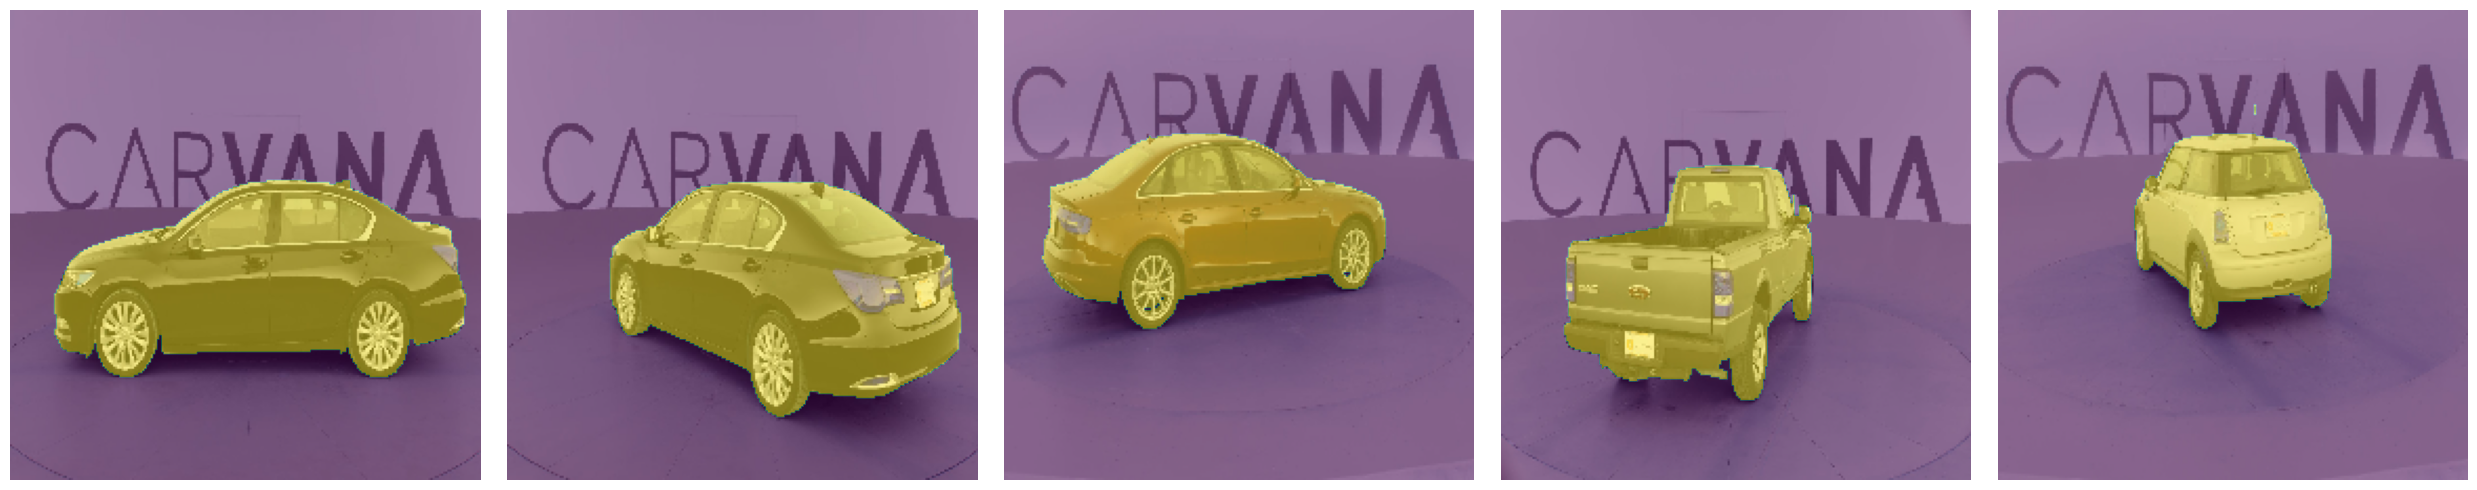

In [17]:
plot_batch(imgs, msks, size=5)

In [18]:
import gc
gc.collect()

8935

# 📦 Model

In [19]:
from torch import nn
import torch


def double_conv(in_c, out_c):
    layer = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3 , padding=1),
            nn.ReLU(),)
    return layer


def resize_feature(original, target):
    original_size = original.shape[2]
    target_size = target.shape[2]
    delta = original_size - target_size  # 64 - 56
    delta = delta // 2
    return original[:, :, delta: original_size - delta, delta: original_size-delta]


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = double_conv(3, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        self.conv5 = double_conv(512, 1024)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.conv6 = double_conv(1024, 512)
        self.conv7 = double_conv(512, 256)
        self.conv8 = double_conv(256, 128)
        self.conv9 = double_conv(128, 64)

        self.out = nn.Conv2d(64, self.out_channels, kernel_size=3, padding=1)


    def forward(self, xb):
        # encoder - 1x1x572x572
        x1 = self.conv1(xb) # (64x568x568)
        x2 = self.max_pool(x1)
        x3 = self.conv2(x2) # (128x280x280)
        x4 = self.max_pool(x3)
        x5 = self.conv3(x4) # (256x136x136)
        x6 = self.max_pool(x5)
        x7 = self.conv4(x6) # (512x64x64)
        x8 = self.max_pool(x7)
        x9 = self.conv5(x8) ## (1024x28x28)

        # upconv -> resize and concat -> conv
        x10 = self.up_conv1(x9)
        x11 = torch.cat((x10, resize_feature(x7, x10)), dim=1)
        x12 =self.conv6(x11)

        x13 = self.up_conv2(x12)
        x14 = torch.cat((x13, resize_feature(x5, x13)), dim=1)
        x15 =self.conv7(x14)

        x16 = self.up_conv3(x15)
        x17 = torch.cat((x16, resize_feature(x3, x16)), dim=1)
        x18 =self.conv8(x17)

        x18 = self.up_conv4(x18)
        x19 = torch.cat((x18, resize_feature(x1, x18)), dim=1)
        x20 =self.conv9(x19)

        out = self.out(x20)
        return out


if __name__ == "__main__":
    xb = torch.randn(20, 3, 224, 224)
    model = UNet()
    out = model(xb)
    print(out.shape)


torch.Size([20, 1, 224, 224])


In [20]:
def build_model():
    model = UNet()
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [21]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [22]:
print(imgs.shape, msks.shape)
out = model(imgs)
out.shape

torch.Size([20, 3, 224, 224]) torch.Size([20, 1, 224, 224])


torch.Size([20, 1, 224, 224])

In [23]:
criterion = BCEWithLogitsLoss()
criterion(out, msks)

tensor(0.6973, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [24]:
del model, imgs, msks, out

import gc
gc.collect()

0

# 🚄 Training Function

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True, device_type=device):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [26]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [27]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    # wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


# 🔍 Optimizer

In [28]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [29]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

# 🚅 Training

In [33]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='carvana image masking challenge', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: Tesla T4

Epoch 1/5

Valid : 100%|██████████| 5/5 [00:02<00:00,  1.69it/s, gpu_memory=7.04 GB, lr=0.00200, valid_loss=5.2328]


Valid Dice: 0.0000 | Valid Jaccard: 0.0000
Valid Score Improved (-inf ---> 0.0000)
Model Saved


Epoch 2/5

Valid : 100%|██████████| 5/5 [00:03<00:00,  1.64it/s, gpu_memory=7.47 GB, lr=0.00200, valid_loss=0.4958]


Valid Dice: 0.0000 | Valid Jaccard: 0.0000
Valid Score Improved (0.0000 ---> 0.0000)
Model Saved


Epoch 3/5

Valid : 100%|██████████| 5/5 [00:03<00:00,  1.62it/s, gpu_memory=7.40 GB, lr=0.00200, valid_loss=11.9752]


Valid Dice: 0.3535 | Valid Jaccard: 0.2169
Valid Score Improved (0.0000 ---> 0.3535)
Model Saved


Epoch 4/5

Valid : 100%|██████████| 5/5 [00:03<00:00,  1.67it/s, gpu_memory=7.48 GB, lr=0.00200, valid_loss=0.4976]


Valid Dice: 0.0000 | Valid Jaccard: 0.0000


Epoch 5/5

Valid : 100%|██████████| 5/5 [00:02<00:00,  1.68it/s, gpu_memory=7.44 GB, lr=0.00200, valid_loss=0.4430]


Valid Dice: 0.0000 | Valid Jaccard: 0.0000


Training complete in 0h 0m 46s
Best Score: 0.2169


LR,█▇▆▄▁
Train Loss,▂▃▅█▁
Valid Dice,▁▁█▁▁
Valid Jaccard,▁▁█▁▁
Valid Loss,▄▁█▁▁
Best Dice,0.35349
Best Epoch,3
Best Jaccard,0.21688
LR,0.002
Train Loss,0.44332
Valid Dice,0.0


# 🔭 Prediction

In [36]:
test_dataset = BuildDataset(df.query("fold==0").sample(frac=1.0), train=False, 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

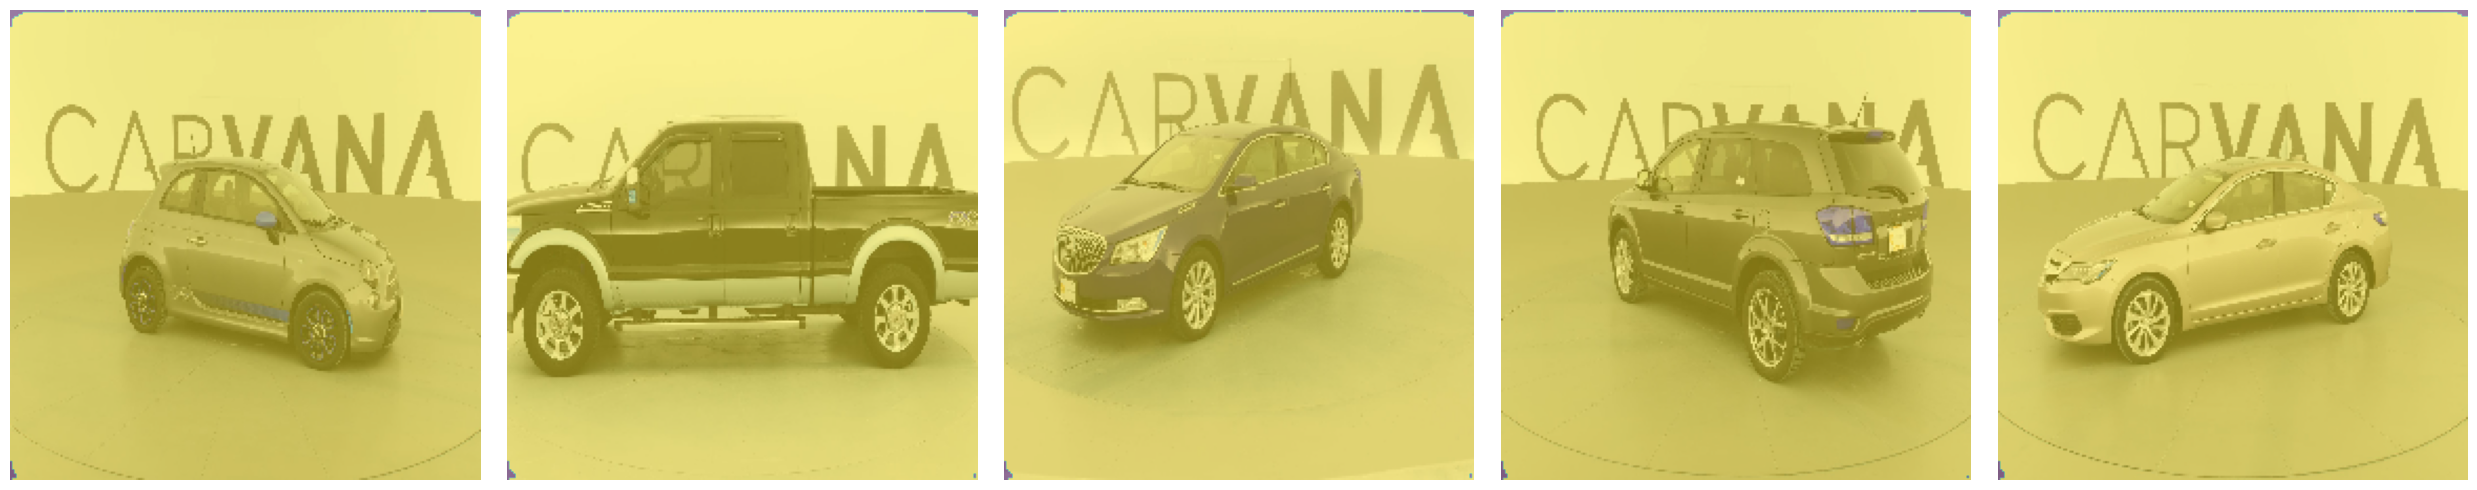

In [37]:
plot_batch(imgs, preds, size=5)

# ✂️ Remove Files

In [38]:
!rm -r ./wandb